In [0]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Colab Notebooks/"
work_dir = "/content"
import sys
if not path in sys.path: sys.path.append(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch, torchvision, os, requests, random, time
import torch.nn as nn
from io import BytesIO
from PIL import Image
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm
!pip install onnxruntime
import onnx
import onnxruntime as ort
#import caffe2.python.onnx.backend as backend
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours
import colorsys
from itertools import chain

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Memory profiler: Using : %%memit or %mprun -f {imported function} {imported function}(args)
# https://pypi.org/project/memory-profiler/
!pip install memory_profiler
%load_ext memory_profiler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

     |████████████████████████████████| 3.7MB 2.8MB/s 
     |████████████████████████████████| 4.8MB 39.6MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=4cbf6a3c3ac9c0740a942f48196973895c4d8b1fb74b11cbe1736d61c48a42c8
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
cpu


##Some usefull functions

In [0]:
def compare_tensors(a, b):
    if torch.all(a == b).item():
        print('Absolutelly the same!')
    else:
        print('Tensors differs!!!')

def compare_arrays(a, b, atol=1e-5, rtol=1e-05):    
    np.testing.assert_allclose(a, b, atol=atol, rtol=rtol)
    print(f'Equal to tolerence: atol={atol}, rtol={rtol}')    
        

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')    

def get_image_tensor(url='https://www.sb.by/upload/iblock/e26/e2695b04032819905a3150f90ef27dd9.jpg'):
    return torchvision.transforms.ToTensor()(
        Image.open(BytesIO(requests.get(url).content)))
    
def get_pil_image(url='https://www.sb.by/upload/iblock/e26/e2695b04032819905a3150f90ef27dd9.jpg'):
    return Image.open(BytesIO(requests.get(url).content))

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, prediction, class_names=None,
                      scores=None, title="",
                      figsize=(10, 10), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, N=12, tresh=0.7):
    """
    prediction: Dict:
    	boxes: [num_instances, (y1, x1, y2, x2)] in image coordinates.
    	masks: [num_instances, height, width]
    	labels: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    N: number of boxes to show
    """

    def apply_mask(image, mask, color, alpha=0.5):
        """Apply the given mask to the image.
        """
        for c in range(3):
            image[:, :, c] = np.where(mask == 1,
                                    image[:, :, c] *
                                    (1 - alpha) + alpha * color[c],
                                    image[:, :, c])
        return image

    if class_names is None:
        class_names = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate',
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table',
    'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush',
    'hair brush',]

    # converting predicted data and image    
    if not isinstance(prediction, (dict)):      
        boxes = prediction.detach().cpu().numpy()
        labels = None
        masks = None
        scores = None
    else:  # prediction is prediction not targets not boxes itself
        scores = prediction.get('scores', None)
        if scores is not None:
            if N > (scores > tresh).sum(): N = (scores > tresh).sum()        
        boxes = prediction['boxes'][:N].detach().cpu().numpy()
        masks = prediction.get('masks', None)
        if masks is not None: 
            masks = (masks.squeeze()[:N].detach().cpu().numpy() > 0.5)
        labels = prediction['labels'][:N].detach().cpu().numpy().astype(np.uint8)
    if type(image) is torch.Tensor:
        image = np.array(torchvision.transforms.ToPILImage()(image))
    # Number of instances
    N = boxes.shape[0]
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if labels is not None:
            if not captions:
                class_id = labels[i]
                score = scores[i] if scores is not None else None
                label = class_names[class_id]
                caption = "{} {:.3f}".format(label, score) if score else label
            else:
                caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                    color='w', size=11, backgroundcolor="none")

        # Mask
        if masks is not None:
            mask = masks[i]
            if show_mask:
                masked_image = apply_mask(masked_image, mask, color)        
            ax.imshow(masked_image)

            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)

            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
        else:
            ax.imshow(image)

    if auto_show:
        plt.show() 


## Numpy transformation class

In [0]:
class NumpyTransforms():
    """
    Performs PIL Image transformation before feeding the data to a model.
    The transformations it perform are:
        - image resize to defined image_size for max(height/width) proportionally
        - convert to numpy array
        - input normalization (mean subtraction and std division)
        - pad numpy array to size
            padded_size*padded_size that are multiplies of size_divisible
    It returns a numpy array and a resized image size without padding
    """

    def __init__(self, image_size=800, size_divisible=32, image_mean=[0.485, 0.456, 0.406],
                 image_std=[0.229, 0.224, 0.225]):
        self.image_size = image_size
        self.mean = np.array(image_mean, dtype=np.float32)
        self.std = np.array(image_std, dtype=np.float32)
        self.size_divisible = size_divisible

    def __call__(self, image, normalize=True):
        if not isinstance(image, Image.Image):
            raise ValueError("image is expected to be PIL Image "
                             ", got {}".format(type(image)))
        image = self.resize(image, self.image_size)
        image = self.from_PIL(image)
        if normalize:
            image = (image - self.mean[:, None, None]) / self.std[:, None, None]
        image_size = image.shape[-2:]
        image = self.batch_image(image, self.size_divisible)[None]
        return image, image_size

    def from_PIL(self, img):
        return np.array(img, dtype=np.float32).transpose(2, 0, 1) / 255

    def to_PIL(self, img):
        # only one image [C, H ,W] is allowed
        if img.ndim > 3: img = img[0]
        return Image.fromarray((img.transpose(1, 2, 0) * 255).astype(np.uint8), mode="RGB")

    def denorm_to_PIL(self, img):
        # only one image [C, H ,W] is allowed
        if img.ndim > 3: img = img[0]
        img = (img * self.std[:, None, None]) + self.mean[:, None, None]
        return self.to_PIL(img)

    def batch_image(self, image, size_divisible=32.):
        self.padded_size = int(np.ceil(float(self.image_size) / size_divisible) * size_divisible)

        padding = [(self.padded_size - s2) for s2 in image.shape[-2:]]
        padded_img = np.pad(image, ((0, 0), (0, padding[0]), (0, padding[1])))
        return padded_img

    def resize(self, image, size):
        w, h = image.size
        scale_factor = min(size/w, size/h)
        new_h = int(h * scale_factor)
        new_w = int(w * scale_factor)
        return image.resize((new_w, new_h), Image.BICUBIC)


##ResNet101, ResNet34, MobileNetv2 completely

In [0]:
models = {
    'mobilenetv2': torchvision.models.resnet34(pretrained=True),
    'resnet34': torchvision.models.mobilenet_v2(pretrained=True),
    'resnet101':torchvision.models.resnet101(pretrained=True)
}
for m in models.values():
    m.eval()
print()
inference_size = 224

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
t = NumpyTransforms(image_size=inference_size)
numpy_transform_output, image_size = t(get_pil_image(), normalize=True)
dummy_input = torch.from_numpy(numpy_transform_output)
print(dummy_input.shape)
input_names = ["image_input"]
output_names = ["out"]
for key, model in models.items():
    torch.onnx.export (model, dummy_input, 
                    f=os.path.join(path, 
                        f'{key}_onnx_v11_{t.image_size}x{t.image_size}.onnx'),
                    input_names=input_names,
                    output_names=output_names,
                    opset_version=11,
                    verbose=True)

torch.Size([1, 3, 224, 224])
graph(%image_input : Float(1, 3, 224, 224),
      %conv1.weight : Float(64, 3, 7, 7),
      %bn1.weight : Float(64),
      %bn1.bias : Float(64),
      %bn1.running_mean : Float(64),
      %bn1.running_var : Float(64),
      %bn1.num_batches_tracked : Long(),
      %layer1.0.conv1.weight : Float(64, 64, 3, 3),
      %layer1.0.bn1.weight : Float(64),
      %layer1.0.bn1.bias : Float(64),
      %layer1.0.bn1.running_mean : Float(64),
      %layer1.0.bn1.running_var : Float(64),
      %layer1.0.bn1.num_batches_tracked : Long(),
      %layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %layer1.0.bn2.weight : Float(64),
      %layer1.0.bn2.bias : Float(64),
      %layer1.0.bn2.running_mean : Float(64),
      %layer1.0.bn2.running_var : Float(64),
      %layer1.0.bn2.num_batches_tracked : Long(),
      %layer1.1.conv1.weight : Float(64, 64, 3, 3),
      %layer1.1.bn1.weight : Float(64),
      %layer1.1.bn1.bias : Float(64),
      %layer1.1.bn1.running_mean : Floa

In [0]:
t = NumpyTransforms(image_size=inference_size)
image = get_pil_image('https://cdn.pixabay.com/photo/2020/03/09/08/38/eurasian-wigeon-4914971_960_720.jpg')
image_orig_size = image.size
numpy_transform_output, im_size = t(image, normalize=True)
print(numpy_transform_output.shape)
for key, model in models.items():
    ort_session = ort.InferenceSession(os.path.join(path, f'{key}_onnx_v11_{t.image_size}x{t.image_size}.onnx'))
    outputs_numpy = ort_session.run(None, {'image_input': numpy_transform_output})
    outputs_torch = model(torch.from_numpy(numpy_transform_output))
    print(f'Model {key}. output shape: {np.array(outputs_numpy).shape}')
    compare_arrays(outputs_numpy[0], outputs_torch.detach().cpu().numpy(), atol=1e-4)

(1, 3, 224, 224)
Model mobilenetv2. output shape: (1, 1, 1000)
Equal to tolerence: atol=0.0001, rtol=1e-05
Model resnet34. output shape: (1, 1, 1000)
Equal to tolerence: atol=0.0001, rtol=1e-05
Model resnet101. output shape: (1, 1, 1000)
Equal to tolerence: atol=0.0001, rtol=1e-05


##FasterRCNN completely

In [0]:
faster = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#faster.transform.min_size = (600,)
#faster.transform.max_size = 600
faster.eval()
print()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
t = NumpyTransforms(image_size=800)
numpy_transform_output =np.array(get_pil_image(), dtype=np.float32).transpose(2, 0, 1) / 255
dummy_input = torch.from_numpy(numpy_transform_output)[None]
print(dummy_input.shape)
input_names = ["image_input"]
output_names = ["boxes","labels","scores" ]
#input_names=['input', 'h0', 'c0'],
                    #output_names=['output', 'hn', 'cn'],
                    #dynamic_axes={'input': {0: 'sequence'}, 'output': {0: 'sequence'}})
torch.onnx.export (faster, dummy_input, 
                    f=os.path.join(path, 
                        f'fasterRCNN_onnx_v11_dynamic.onnx'),
                    input_names=input_names,
                    output_names=output_names,
                    dynamic_axes={'image_input': {2: 'height', 3: 'width'}},
                    opset_version=11,
                    verbose=True)

torch.Size([1, 3, 599, 900])


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:461: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1951: UserWarning: Exporting aten::index operator of advanced indexing in opset 11 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  "If indices include negative values, the exported graph will produce incorrect results.")


graph(%image_input : Float(1, 3, 599, 900),
      %backbone.body.conv1.weight : Float(64, 3, 7, 7),
      %backbone.body.bn1.weight : Float(64),
      %backbone.body.bn1.bias : Float(64),
      %backbone.body.bn1.running_mean : Float(64),
      %backbone.body.bn1.running_var : Float(64),
      %backbone.body.layer1.0.conv1.weight : Float(64, 64, 1, 1),
      %backbone.body.layer1.0.bn1.weight : Float(64),
      %backbone.body.layer1.0.bn1.bias : Float(64),
      %backbone.body.layer1.0.bn1.running_mean : Float(64),
      %backbone.body.layer1.0.bn1.running_var : Float(64),
      %backbone.body.layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %backbone.body.layer1.0.bn2.weight : Float(64),
      %backbone.body.layer1.0.bn2.bias : Float(64),
      %backbone.body.layer1.0.bn2.running_mean : Float(64),
      %backbone.body.layer1.0.bn2.running_var : Float(64),
      %backbone.body.layer1.0.conv3.weight : Float(256, 64, 1, 1),
      %backbone.body.layer1.0.bn3.weight : Float(256),
      %

In [0]:
t = NumpyTransforms(image_size=800)
numpy_transform_output, image_size = t(get_pil_image(), normalize=False)
dummy_input = torch.from_numpy(numpy_transform_output)
print(dummy_input.shape)
input_names = ["image_input"]
output_names = ["boxes","labels","scores" ]
torch.onnx.export (faster, dummy_input, 
                    f=os.path.join(path, 
                        f'fasterRCNN_onnx_v11_800x800.onnx'),
                    input_names=input_names,
                    output_names=output_names,
                    opset_version=11,
                    verbose=True)

torch.Size([1, 3, 800, 800])


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:461: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1951: UserWarning: Exporting aten::index operator of advanced indexing in opset 11 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  "If indices include negative values, the exported graph will produce incorrect results.")


graph(%image_input : Float(1, 3, 800, 800),
      %backbone.body.conv1.weight : Float(64, 3, 7, 7),
      %backbone.body.bn1.weight : Float(64),
      %backbone.body.bn1.bias : Float(64),
      %backbone.body.bn1.running_mean : Float(64),
      %backbone.body.bn1.running_var : Float(64),
      %backbone.body.layer1.0.conv1.weight : Float(64, 64, 1, 1),
      %backbone.body.layer1.0.bn1.weight : Float(64),
      %backbone.body.layer1.0.bn1.bias : Float(64),
      %backbone.body.layer1.0.bn1.running_mean : Float(64),
      %backbone.body.layer1.0.bn1.running_var : Float(64),
      %backbone.body.layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %backbone.body.layer1.0.bn2.weight : Float(64),
      %backbone.body.layer1.0.bn2.bias : Float(64),
      %backbone.body.layer1.0.bn2.running_mean : Float(64),
      %backbone.body.layer1.0.bn2.running_var : Float(64),
      %backbone.body.layer1.0.conv3.weight : Float(256, 64, 1, 1),
      %backbone.body.layer1.0.bn3.weight : Float(256),
      %

In [0]:
t = NumpyTransforms(image_size=800)
image = get_pil_image('https://cdn.pixabay.com/photo/2020/03/09/08/38/eurasian-wigeon-4914971_960_720.jpg')
image_orig_size = image.size
numpy_transform_output, im_size = t(image, normalize=False)
print(numpy_transform_output.shape)
ort_session = ort.InferenceSession(os.path.join(path, f'fasterRCNN_onnx_v11_800x800.onnx'))
outputs_numpy = ort_session.run(None, {'image_input': numpy_transform_output})
outputs_torch = faster([torch.from_numpy(numpy_transform_output)[0]])[0]
compare_arrays(outputs_numpy[0], outputs_torch['boxes'].detach().cpu().numpy())

(1, 3, 800, 800)
Equal to tolerence: atol=1e-05, rtol=1e-05


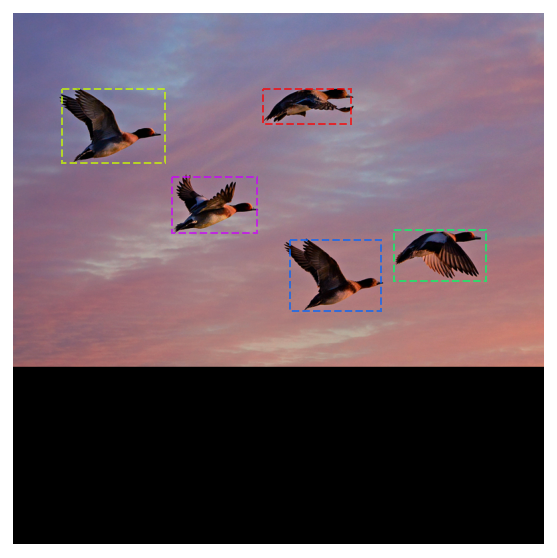

In [0]:
display_instances(torchvision.transforms.ToTensor()(t.to_PIL(numpy_transform_output)), torch.from_numpy(outputs_numpy[0]), tresh=0.7)

##MaskRCNN completely

In [0]:
maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
#maskrcnn.transform.min_size = (600,)
#maskrcnn.transform.max_size = 600
maskrcnn.eval()
print()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [0]:
t = NumpyTransforms(image_size=800)
numpy_transform_output, image_size = t(get_pil_image(), normalize=False)
dummy_input = torch.from_numpy(numpy_transform_output)
print(dummy_input.shape)
input_names = ["image_input"]
output_names = ["boxes","labels","scores", "masks" ]
torch.onnx.export (maskrcnn, dummy_input, 
                    f=os.path.join(path, 
                        f'maskrcnn_onnx_v11_800x800.onnx'),
                    input_names=input_names,
                    output_names=output_names,
                    opset_version=11,
                    verbose=True)

torch.Size([1, 3, 800, 800])


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:461: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/torchvision/models/detection/roi_heads.py:392: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(M + 2 * padding).to(torch.float32) / torch.tensor(M).to(torch.float32)
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1951: UserWarning: Exporting aten::index operator of advanced indexing in opset 11 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative value

graph(%image_input : Float(1, 3, 800, 800),
      %backbone.body.conv1.weight : Float(64, 3, 7, 7),
      %backbone.body.bn1.weight : Float(64),
      %backbone.body.bn1.bias : Float(64),
      %backbone.body.bn1.running_mean : Float(64),
      %backbone.body.bn1.running_var : Float(64),
      %backbone.body.layer1.0.conv1.weight : Float(64, 64, 1, 1),
      %backbone.body.layer1.0.bn1.weight : Float(64),
      %backbone.body.layer1.0.bn1.bias : Float(64),
      %backbone.body.layer1.0.bn1.running_mean : Float(64),
      %backbone.body.layer1.0.bn1.running_var : Float(64),
      %backbone.body.layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %backbone.body.layer1.0.bn2.weight : Float(64),
      %backbone.body.layer1.0.bn2.bias : Float(64),
      %backbone.body.layer1.0.bn2.running_mean : Float(64),
      %backbone.body.layer1.0.bn2.running_var : Float(64),
      %backbone.body.layer1.0.conv3.weight : Float(256, 64, 1, 1),
      %backbone.body.layer1.0.bn3.weight : Float(256),
      %

In [0]:
t = NumpyTransforms(image_size=800)
image = get_pil_image('https://cdn.pixabay.com/photo/2020/03/09/08/38/eurasian-wigeon-4914971_960_720.jpg')
image_orig_size = image.size
numpy_transform_output, im_size = t(image, normalize=False)
print(numpy_transform_output.shape)
ort_session = ort.InferenceSession(os.path.join(path, f'maskrcnn_onnx_v11_800x800.onnx'))
outputs_numpy = ort_session.run(None, {'image_input': numpy_transform_output})
outputs_torch = maskrcnn([torch.from_numpy(numpy_transform_output)[0]])[0]
compare_arrays(outputs_numpy[0], outputs_torch['boxes'].detach().cpu().numpy())
compare_arrays(outputs_numpy[3], outputs_torch['masks'].detach().cpu().numpy())

(1, 3, 800, 800)
Equal to tolerence: atol=1e-05, rtol=1e-05
Equal to tolerence: atol=1e-05, rtol=1e-05


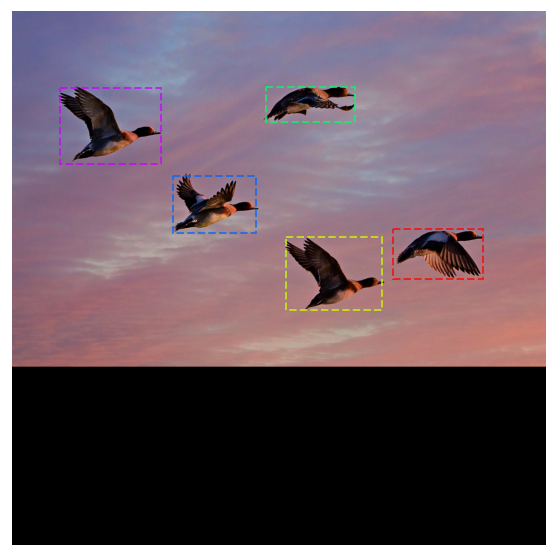

In [0]:
display_instances(torchvision.transforms.ToTensor()(t.to_PIL(numpy_transform_output)), torch.from_numpy(outputs_numpy[0]), tresh=0.7)

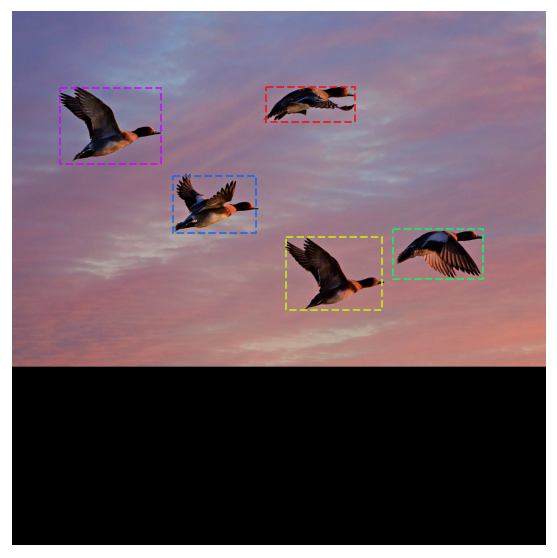

In [0]:
display_instances(torchvision.transforms.ToTensor()(t.to_PIL(numpy_transform_output)), outputs_torch['boxes'], tresh=0.7)

##DeeplLab3 ResNet101 completely

In [0]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()
print()

In [0]:
t = NumpyTransforms(image_size=1024)
numpy_transform_output, image_size = t(get_pil_image(), normalize=True)
dummy_input = torch.from_numpy(numpy_transform_output)
print(dummy_input.shape)
input_names = ["image_input"]
output_names = ["out","aux" ]
torch.onnx.export (model, dummy_input, 
                    f=os.path.join(path, 
                        f'DeepLab3Resnet101_onnx_v11_1024x1024.onnx'),
                    input_names=input_names,
                    output_names=output_names,
                    opset_version=11,
                    verbose=True)

torch.Size([1, 3, 1024, 1024])
graph(%image_input : Float(1, 3, 1024, 1024),
      %backbone.conv1.weight : Float(64, 3, 7, 7),
      %backbone.bn1.weight : Float(64),
      %backbone.bn1.bias : Float(64),
      %backbone.bn1.running_mean : Float(64),
      %backbone.bn1.running_var : Float(64),
      %backbone.bn1.num_batches_tracked : Long(),
      %backbone.layer1.0.conv1.weight : Float(64, 64, 1, 1),
      %backbone.layer1.0.bn1.weight : Float(64),
      %backbone.layer1.0.bn1.bias : Float(64),
      %backbone.layer1.0.bn1.running_mean : Float(64),
      %backbone.layer1.0.bn1.running_var : Float(64),
      %backbone.layer1.0.bn1.num_batches_tracked : Long(),
      %backbone.layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %backbone.layer1.0.bn2.weight : Float(64),
      %backbone.layer1.0.bn2.bias : Float(64),
      %backbone.layer1.0.bn2.running_mean : Float(64),
      %backbone.layer1.0.bn2.running_var : Float(64),
      %backbone.layer1.0.bn2.num_batches_tracked : Long(),
   

In [0]:
t = NumpyTransforms(image_size=1024)
image = get_pil_image('https://cdn.pixabay.com/photo/2020/03/09/08/38/eurasian-wigeon-4914971_960_720.jpg')
image_orig_size = image.size
numpy_transform_output, im_size = t(image, normalize=True)
print(numpy_transform_output.shape)
ort_session = ort.InferenceSession(os.path.join(path, f'DeepLab3Resnet101_onnx_v11_1024x1024.onnx'))
outputs_numpy = ort_session.run(None, {'image_input': numpy_transform_output})[0]
outputs_torch = model(torch.from_numpy(numpy_transform_output))['out']
compare_arrays(outputs_numpy, outputs_torch.detach().cpu().numpy())


(1, 3, 1024, 1024)


AssertionError: ignored

(1, 21, 1024, 1024)
(21, 682, 1024)
(682, 1024)
[0 3]
[655024  43344]
['#00ffff', '#ff0000']
(3, 682, 1024)
(array([  0, 255], dtype=uint8), array([655024,  43344]))
[(0, '#00ffff'), (3, '#ff0000')]


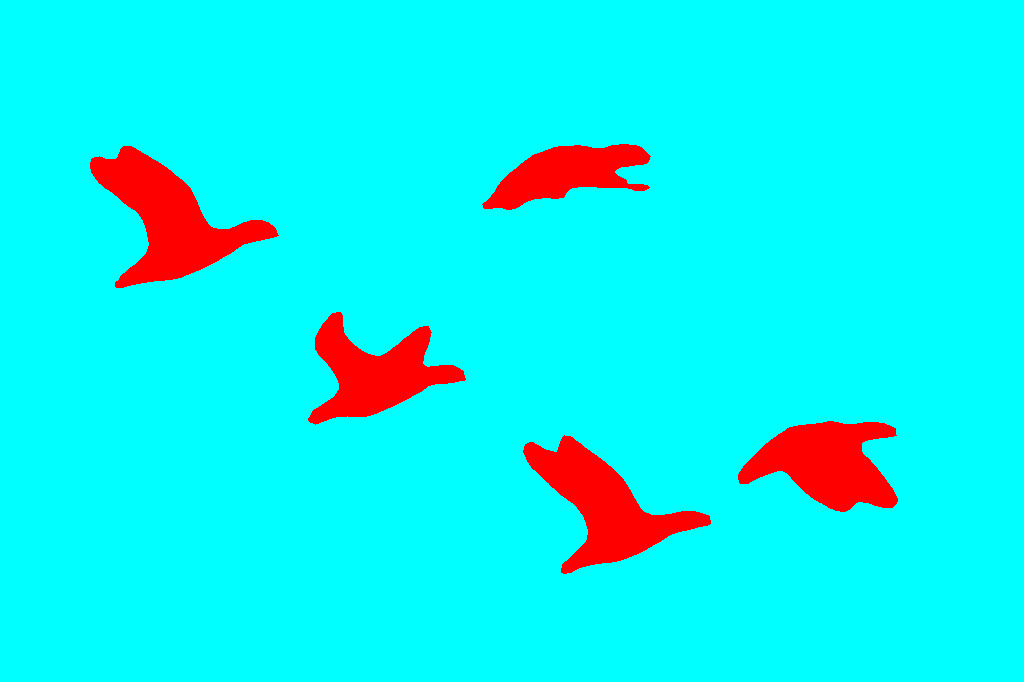

In [0]:
def hex_colours(col):
    def clamp(x):
        return max(0, min(x, 255))

    return "#{0:02x}{1:02x}{2:02x}".format(clamp(col[0]), clamp(col[1]), clamp(col[2]))


# from https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return [hex_colours((round(r * 255), round(g * 255), round(b * 255))) for r, g, b in colors]



print(outputs_numpy.shape)
out = outputs_numpy[0, :, : im_size[0], :im_size[1]]
print(out.shape)
img_seg = np.argmax(out, 0)
print(img_seg.shape)
classes_in_image, counts = np.unique(img_seg, return_counts=True)
print(classes_in_image)
print(counts)
classes_in_image = classes_in_image[:10]
colors = random_colors(len(classes_in_image))
print(colors)
r = np.zeros_like(img_seg, dtype=np.uint8)
g = np.zeros_like(img_seg, dtype=np.uint8)
b = np.zeros_like(img_seg, dtype=np.uint8)
for i, c in enumerate(classes_in_image):
    mask = img_seg == c
    r[mask], g[mask], b[mask] = tuple(int(colors[i][j:j + 2], 16)
                                        for j in (1, 3, 5))
img_seg = np.concatenate([r[None],g[None],b[None]], 0)    
print(img_seg.shape)
print(np.unique(r, return_counts=True))
img = t.to_PIL(img_seg/255)
print([(cl,c) for cl, c in zip(classes_in_image, colors)])
img

##FCNResNet101 completely

In [0]:
model = torchvision.models.segmentation.fcn_resnet101(pretrained=True)
model.eval()
print()

In [0]:
t = NumpyTransforms(image_size=1024)
numpy_transform_output, image_size = t(get_pil_image(), normalize=True)
dummy_input = torch.from_numpy(numpy_transform_output)
print(dummy_input.shape)
input_names = ["image_input"]
output_names = ["out","aux" ]
torch.onnx.export (model, dummy_input, 
                    f=os.path.join(path, 
                        f'FCNResnet101_onnx_v11_1024x1024.onnx'),
                    input_names=input_names,
                    output_names=output_names,
                    opset_version=11,
                    verbose=True)

torch.Size([1, 3, 1024, 1024])
graph(%image_input : Float(1, 3, 1024, 1024),
      %backbone.conv1.weight : Float(64, 3, 7, 7),
      %backbone.bn1.weight : Float(64),
      %backbone.bn1.bias : Float(64),
      %backbone.bn1.running_mean : Float(64),
      %backbone.bn1.running_var : Float(64),
      %backbone.bn1.num_batches_tracked : Long(),
      %backbone.layer1.0.conv1.weight : Float(64, 64, 1, 1),
      %backbone.layer1.0.bn1.weight : Float(64),
      %backbone.layer1.0.bn1.bias : Float(64),
      %backbone.layer1.0.bn1.running_mean : Float(64),
      %backbone.layer1.0.bn1.running_var : Float(64),
      %backbone.layer1.0.bn1.num_batches_tracked : Long(),
      %backbone.layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %backbone.layer1.0.bn2.weight : Float(64),
      %backbone.layer1.0.bn2.bias : Float(64),
      %backbone.layer1.0.bn2.running_mean : Float(64),
      %backbone.layer1.0.bn2.running_var : Float(64),
      %backbone.layer1.0.bn2.num_batches_tracked : Long(),
   

In [0]:
t = NumpyTransforms(image_size=1024)
image = get_pil_image('https://cdn.pixabay.com/photo/2020/03/09/08/38/eurasian-wigeon-4914971_960_720.jpg')
image_orig_size = image.size
numpy_transform_output, im_size = t(image, normalize=True)
print(numpy_transform_output.shape)
ort_session = ort.InferenceSession(os.path.join(path, f'FCNResnet101_onnx_v11_1024x1024.onnx'))
outputs_numpy = ort_session.run(None, {'image_input': numpy_transform_output})[0]
outputs_torch = model(torch.from_numpy(numpy_transform_output))['out']
compare_arrays(outputs_numpy, outputs_torch.detach().cpu().numpy())


(1, 3, 1024, 1024)


AssertionError: ignored

#Model size utils

In [0]:
def object_size(o, handlers={}, verbose=False, seen=None):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, dict, set.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """

    from itertools import chain
    from reprlib import repr
    from functools import partial
    from types import ModuleType, FunctionType

    # Custom objects know their class.
    # Function objects seem to know way too much, including modules.
    # Exclude modules as well.
    BLACKLIST = type, ModuleType, FunctionType

    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                    }
    all_handlers.update(handlers)  # user handlers take precedence
    if seen is None: seen = set()  # track which object id's have already been seen
    default_size = sys.getsizeof(0)  # estimate sizeof object without __sizeof__

    def sizeof(o, level=0):
        if isinstance(o, BLACKLIST):
            print('sizeof() does not take argument of type: ' + str(type(o)))

        if id(o) in seen:  # do not double count the same object
            return 0

        seen.add(id(o))
        n = repr(o)
        if torch.is_tensor(o) or (hasattr(o, 'data') and torch.is_tensor(o.data)):
            s = sys.getsizeof(o.storage(), default_size)
            n = 'Shape: ' + str(tuple(o.size())) if torch.is_tensor(o) else str(tuple(o.data.size()))
        elif (hasattr(o, 'saved_tensors') and torch.is_tensor(o.saved_tensors)):
            n = 'Saved_T_shape:  ' + str(tuple(o.saved_tensors.size()))
        elif isinstance(o, (np.ndarray, np.generic)):
            s = o.nbytes
            n = 'Shape: ' + str(o.shape)
        else:
            s = sys.getsizeof(o, default_size)

        if verbose:
            print(
                '{} {:<10} \t {:>10} bytes;  {}'.format(' ' * 2 * level, str(type(o)).split('\'')[-2].split('.')[-1], s,
                                                        n))

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(partial(sizeof, level=level + 1), handler(o)))
                break
        return s

    return sizeof(o)

def model_summarize(model, level=0,
                    verbose=False,
                    show_weights=True,
                    show_parameters=True,
                    show_sizes=True):
    """Summarizes torch model by showing trainable parameters and weights."""

    def module_summarize(module, name='', sum_of_params=0, sum_of_sizes=0, level=level):
        # if it contains layers let call it recursively to get params and weights
        if len(module._modules.values()) > 0:
            if verbose:
                print('{}{} {}: '.format('  ' * level, name, module.__class__.__name__))
            for key, mod in module._modules.items():
                p, s = module_summarize(mod, name='(' + key + ')', level=level + 1)
                sum_of_params += p
                sum_of_sizes += s
        else:
            params = sum([np.prod(p.size()) for p in module.parameters()])
            weights = tuple([tuple(p.size()) for p in module.parameters()])
            size = sum([object_size(p) for p in module.parameters()])
            sum_of_params += params
            sum_of_sizes += size
            weight_str = '{:<25}'.format('W: ' + str(weights)) if show_weights else ''
            params_str = '{:<15}'.format('P: ' + str(params)) if show_parameters else ''
            size_str = '{:<12}'.format('S: ' + str(size)) if show_sizes else ''
            if verbose:
                print(
                    '{}{:<8} {}{}{} {}'.format('  ' * level, name, size_str, params_str, weight_str, module.__repr__()))

        return sum_of_params, sum_of_sizes

    return module_summarize(model)

In [0]:
model_summarize(model, verbose=True)

 FCN: 
  (backbone) IntermediateLayerGetter: 
    (conv1)  S: 37696    P: 9408        W: ((64, 3, 7, 7),)       Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1)    S: 640      P: 128         W: ((64,), (64,))         BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu)   S: 0        P: 0           W: ()                     ReLU(inplace=True)
    (maxpool) S: 0        P: 0           W: ()                     MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1) Sequential: 
      (0) Bottleneck: 
        (conv1)  S: 16448    P: 4096        W: ((64, 64, 1, 1),)      Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1)    S: 640      P: 128         W: ((64,), (64,))         BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2)  S: 147520   P: 36864       W: ((64, 64, 3, 3),)      Conv2d(64, 64, kernel_size=(3, 3), st

(54314346, 217277992)